# Battle of the Neighborhoods


## Finding the best Neighbourhood in Riga for Gym/ Fitness Center

### 1.Introduction: Business Problem

The City of Riga, is the capital and most populous city of Latvia. Almost half population of Latvia live or work in Riga. Nowadays in most cases work requires seating for multiple hours a day, which brings very unhealthy static tension to the body. Therefore, various sport venues became more and more popular among student and young workers.
It is quite nice choice for new business but where will be better choice to start? In our case we are interested in venues that combine Gyms and Fitness Center. Why? For example, in Yoga centers most clients are females, but in Gyms – male. We do not want to divide our clients and want to create a center for both, may be for couples or for families.
Therefore, our goal to building a recommendation system for finding best suitable Gym/Fitness Center for “active fitness age” population (young people from 15- 49) based on certain criteria is valuable analytical problem that perfectly fits into Clustering type of Data Science problems which could be solved by unsupervised learning algorithms.
**Target Audience:** Group of activists and investors who want to start “gym/fitness business” in Riga.


**The objective** is to locate and recommend to the client which neighbourhood in Riga will be best choice to start a new fintness center or gym.

### 2. Data

The data that will be required will be a combination of CSV files that have been downloaded for the purposes of the analysis from Central Statistical Bureau of Latvia , the Geographical location of the neighbourhoods (via Geocoder package) and Venue data pertaining to Gym/Fitness Centres in Riga (via Foursquare). The Venue data will help find which neighbourhood is best suitable to open new Gym/Fitness Center.

### 3. Methodology

### 3.1. Collect Inspection Data

Libraries installation

In [1]:
! pip install lxml
! pip install numpy
! pip install pandas
! pip install bs4
! pip install geopy
! pip install geocoder
! pip install matplotlib
! pip install sklearn
! pip install folium
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c anaconda xlrd --yes
!conda install -c conda-forge geopy --yes
print('Installations completed!')

Solving environment: \ 
  - anaconda/osx-64::ca-certificates-2020.1.1-0, anaconda/osx-64::certifi-2019.11.28-py37_0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_4
  - anaconda/osx-64::certifi-2019.11.28-py37_0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_4, defaults/osx-64::ca-certificates-2020.1.1-0
  - anaconda/osx-64::ca-certificates-2020.1.1-0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_4, defaults/osx-64::certifi-2019.11.28-py37_0
  - anaconda/osx-64::openssl-1.1.1d-h1de35cc_4, defaults/osx-64::ca-certificates-2020.1.1-0, defaults/osx-64::certifi-2019.11.28-py37_0
  - anaconda/osx-64::ca-certificates-2020.1.1-0, defaults/osx-64::certifi-2019.11.28-py37_0, defaults/osx-64::openssl-1.1.1d-h1de35cc_4
  - defaults/osx-64::ca-certificates-2020.1.1-0, defaults/osx-64::certifi-2019.11.28-py37_0, defaults/osx-64::openssl-1.1.1d-h1de35cc_4
  - anaconda/osx-64::ca-certificates-2020.1.1-0, anaconda/osx-64::certifi-2019.11.28-py37_0, defaults/osx-64::openssl-1.1.1d-h1de35cc_4
  - anaconda/osx-64::cer

In [215]:
import pandas as pd
import numpy as np

import requests

import geocoder 
from geopy.geocoders import Nominatim 
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import seaborn as sns

import lxml
import folium

import json

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print('Libraries imported.')


Libraries imported.


Collect data about about Neighborhood in Riga  from *Central Statistical Bureau of Latvia.*

In [269]:
# Read csv file with Neighborhoods and population . Calculate total active population 15-49.
file = '/Users/julija/IT/Coursera_Capstone/Coursera_Capstone/TSG11-R02-2.csv'
riga_data = pd.read_csv(file,delimiter=';', header = 1)
column_list = list(riga_data)
column_list.remove("Total")
riga_data['Age 15-49'] = riga_data[column_list].sum(axis=1)
riga_data.drop(['15-24', '25-49'], axis=1, inplace=True)
# Rename column in dataframe and check the shape
riga_data = riga_data.rename(columns={'Neighbourhood':'Neighborhood'})
riga_data = riga_data.rename(columns={'Total':'Total Population'})
riga_data.head(10)


Neighborhood  Total Population  Age 15-49
0  Sarkandaugava             18095       8588
1  Ziepniekkalns             33614      16801
2   Vecmilgravis             22667      10649
3    Daugavgriva              9015       4430
4    Kundzinsala               399        185
5    Ciekurkalns              7794       3942
6      Bisumuiza              2354       1164
7     Tornakalns              6947       3699
8     Agenskalns             26841      13123
9      Dzirciems             12079       5831

Before using data, we will have to explore and understand it.

#### 3.2. Explore and Understand Data

In [219]:
# Check the dataframe
print(riga_data.dtypes)
print(riga_data.shape)

Neighborhood        object
Total Population     int64
Age 15-49            int64
dtype: object
(58, 3)


#### Based on the dataset, there are a total of 58 different Neighborhoods in Riga to select from .

#### 3.3. Data preparation and preprocessing

#### Let's get geo data( latitude & longitude) for Riga and its Neighborhoods.


In [8]:
# Get coordinates for Riga( Latvija)
address = 'Riga, Latvia'

geolocator = Nominatim(user_agent="Riga_explorer")
location = geolocator.geocode(address)
riga_latitude = location.latitude
riga_longitude = location.longitude
print('The geograpical coordinate of Riga(Latvia) are {}, {}.'.format(riga_latitude, riga_longitude))

The geograpical coordinate of Riga(Latvia) are 56.9493977, 24.1051846.


In [9]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

# add coordinates of Neigborhoods
coords = [ get_latlng(neighborhood) for neighborhood in riga_data["Neighborhood"].tolist() ]

riga_coords = pd.DataFrame(coords, columns=['latitude', 'longitude'])

# merge the coordinates into the original dataframe
riga_data['latitude'] = riga_coords['latitude']
riga_data['longitude'] = riga_coords['longitude']
print("Geographical coordinates of five neighborhoods are as below")
riga_data.head()

Geographical coordinates of five neighborhoods are as below


Neighborhood  Total Population  Age 15-49  latitude  longitude
0  Sarkandaugava             18095       8588  56.98857   24.12164
1  Ziepniekkalns             33614      16801  56.89951   24.09832
2   Vecmilgravis             22667      10649  57.03612   24.09670
3    Daugavgriva              9015       4430  57.03731   24.02443
4    Kundzinsala               399        185  57.16667   24.10556

In [6]:
# Check the dataframe
print(riga_data.dtypes)
print(riga_data.shape)

Neighborhood        object
Total Population     int64
Age 15-49            int64
dtype: object
(58, 3)


#### Let's visualize neighborhood centers on the map:

In [15]:

map_riga = folium.Map(location=[riga_latitude, riga_longitude], zoom_start=12)

for _, neighborhood in riga_data.iterrows():
    label = folium.Popup(neighborhood['Neighborhood'], parse_html=True)
    folium.CircleMarker(
        [neighborhood['latitude'], neighborhood['longitude']],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_riga)

map_riga

#### Let's a little bit analize population of neighborhoods in Riga and visualize it:

In [16]:

columns = ['Neighborhood','Total Population']
population_data = pd.DataFrame(riga_data, columns=columns).copy()

population_data.sort_values(by='Total Population', ascending=False, inplace=True)

population_data_top15 = population_data[['Neighborhood','Total Population']].head(15)
population_data_top15.head()

Neighborhood  Total Population
23      Purvciems             59273
26      Kengarags             50366
37         Imanta             46640
24      Plavnieki             44750
1   Ziepniekkalns             33614

Based on the data, Purvciems is the most  populated neigborhood in Riga . We can visualise  top 15

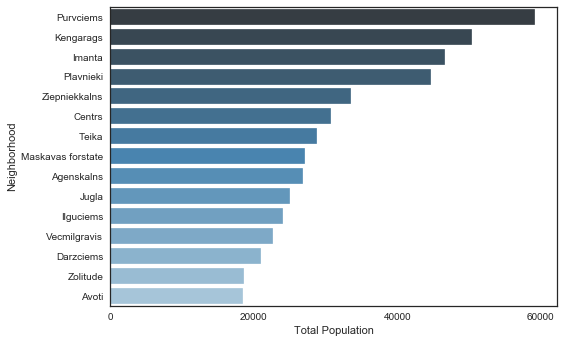

In [17]:
sns.set_style("ticks", {"xtick.major.size": 10, "ytick.major.size": 10})
sns.barplot(x = "Total Population", y = "Neighborhood",  data = population_data_top15, palette=("Blues_d"),capsize = 0.1)
sns.set_context("poster")

What's about population at age 15-49 by Neighborhood? Let's visualise it on Riga map

In [237]:
columns = ['Neighborhood','Age 15-49']
population1549_data = pd.DataFrame(riga_data, columns=columns).copy()

population1549_data.sort_values(by='Age 15-49', ascending=False, inplace=True)

population1549_data_top15 = population1549_data[['Neighborhood','Age 15-49']].head(15)
population1549_data_top15.head()

Neighborhood  Age 15-49
23      Purvciems      28175
26      Kengarags      23345
37         Imanta      21463
24      Plavnieki      21278
1   Ziepniekkalns      16801

In [18]:
# Creating map of Riga with population 15-49
riga_map = folium.Map(location=[riga_latitude, riga_longitude], zoom_start=12,tiles='openstreetmap')
                   
riga_map.choropleth(
    geo_data='/Users/julija/IT/Coursera_Capstone/Apkaimes.json',
    data=riga_data,
    columns=['Neighborhood','Age 15-49'],
    key_on='feature.properties.apkaime',
    fill_color='OrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2, 
    legend_name = 'Population (age 15-49) by neighborhood'
)

riga_map

Foursquare API is used to obtain information about all venues in neighborhoods and *Gym/ Fitness Center* in each neighborhood.

In [10]:
# Define Foursquare Credentials, Version, set up radius, limit for our future requests.

CLIENT_ID = 'IOC3A1OO1SPLTZYRFSMITEY03YAXHK1GW0STCGZ0S0QJWPPI' 
CLIENT_SECRET = 'JTTFXT1NBXFUUIW3S5HHWXAK5ZIH3KYPGYDGZ3LKG2BT3IGL'
VERSION = '20180605' 
LIMIT = 100
radius = 2000

print('Credentials Stored')

Credentials Stored


### 3.4. Modeling

Retrieve information about Neighborhood via Foursquare API call:

In [14]:
# Define a function to get venue list with 2km distance to neighborhood's center for all the neighborhoods in Riga
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat,  lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'Venue ID',           
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

# Run the above function on each neighborhood and create a new dataframe called riga_venues.

riga_venues = getNearbyVenues(riga_data['Neighborhood'],riga_data['latitude'], riga_data['longitude'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(riga_venues['Venue Category'].unique())))
riga_venues.head()

There are 267 unique venue categories. Some of them are as below:


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Sarkandaugava               56.98857                24.12164   
1  Sarkandaugava               56.98857                24.12164   
2  Sarkandaugava               56.98857                24.12164   
3  Sarkandaugava               56.98857                24.12164   
4  Sarkandaugava               56.98857                24.12164   

                        Venue                  Venue ID  Venue Latitude  \
0          MyFitness Sky&More  4f1ec79be4b0454d62987680       56.986270   
1  Boksa Klubs Latvijas Cimdi  4f9eb6b7e4b0edc5630b92c6       56.990587   
2                   Nāc un ēd  535631b6498eb2d3777d377e       56.987213   
3             SKY lielveikals  58668b6865e7c70a2f851761       56.986478   
4                   Radio SWH  4d67ea96052ea1cdee3da049       56.981202   

   Venue Longitude Venue Category  
0        24.132861            Gym  
1        24.122617     Boxing Gym  
2        24.121677         Bistro  
3        24.132768  Grocery Store  
4        24.117657    Music Venue

How many unique venues are there?

In [23]:
print('There are {} uniques categories.'.format(len(riga_venues['Venue Category'].unique())))

There are 267 uniques categories.


In [24]:
print("The Venue Categories are", riga_venues['Venue Category'].unique())

The Venue Categories are ['Gym' 'Boxing Gym' 'Bistro' 'Grocery Store' 'Music Venue'
 'Electronics Store' 'Café' 'Park' 'Sushi Restaurant'
 'Furniture / Home Store' 'Pizza Place' 'History Museum'
 'Gym / Fitness Center' 'Tanning Salon' 'Spa' 'Shopping Mall' 'Museum'
 'Food Court' 'Hotel' 'Farmers Market' 'Arcade' 'Convenience Store'
 'Track' 'Paper / Office Supplies Store' 'Diner' 'American Restaurant'
 'Bike Shop' 'Train Station' 'Pharmacy' 'Pet Store' 'Sports Bar' 'Brewery'
 'Kebab Restaurant' 'Restaurant' 'Office' 'Hobby Shop' 'Auto Garage'
 'Camera Store' 'Basketball Court' 'Bus Stop' 'Tram Station'
 'Harbor / Marina' 'Clothing Store' 'Cafeteria' 'Liquor Store' 'Trail'
 'Boat or Ferry' 'Dumpling Restaurant' 'Vietnamese Restaurant'
 'Gourmet Shop' 'Forest' 'Pool' 'Bakery' 'Middle Eastern Restaurant'
 'Fast Food Restaurant' 'Hostel' 'BBQ Joint' 'Food' 'Warehouse Store'
 'Martial Arts Dojo' 'Gun Shop' 'Performing Arts Venue' 'Scenic Lookout'
 'Dance Studio' 'Cosmetics Shop' 'Bar' 'Casi

Are there any Gyms/Fitness Center in the venues?

In [25]:
"Gym / Fitness Center" in riga_venues['Venue Category'].unique()

True

In [26]:
riga_venues['Venue Category'].value_counts()['Gym / Fitness Center']

103

Now we will analyze each neighborhood

In [28]:
# one hot encoding
riga_onehot = pd.get_dummies(riga_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
riga_onehot['Neighborhoods'] = riga_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [riga_onehot.columns[-1]] + list(riga_onehot.columns[:-1])
riga_onehot = riga_onehot[fixed_columns]

print(riga_onehot.shape)
riga_onehot.head()

(3183, 268)


Neighborhoods  ATM  Accessories Store  Adult Boutique  Airport  \
0  Sarkandaugava    0                  0               0        0   
1  Sarkandaugava    0                  0               0        0   
2  Sarkandaugava    0                  0               0        0   
3  Sarkandaugava    0                  0               0        0   
4  Sarkandaugava    0                  0               0        0   

   American Restaurant  Animal Shelter  Arcade  Argentinian Restaurant  \
0                    0               0       0                       0   
1                    0               0       0                       0   
2                    0               0       0                       0   
3                    0               0       0                       0   
4                    0               0       0                       0   

   Art Gallery  ...  Vietnamese Restaurant  Volleyball Court  Warehouse Store  \
0            0  ...                      0                 0                0   
1            0  ...                      0                 0                0   
2            0  ...                      0                 0                0   
3            0  ...                      0                 0                0   
4            0  ...                      0                 0                0   

   Water Park  Wine Bar  Wine Shop  Winery  Women's Store  Yoga Studio  Zoo  
0           0         0          0       0              0            0    0  
1           0         0          0       0              0            0    0  
2           0         0          0       0              0            0    0  
3           0         0          0       0              0            0    0  
4           0         0          0       0              0            0    0  

[5 rows x 268 columns]

Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [30]:
riga_grouped = riga_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(riga_grouped.shape)
riga_grouped.head()

(57, 268)


Neighborhoods  ATM  Accessories Store  Adult Boutique   Airport  \
0    Agenskalns  0.0                0.0            0.00  0.000000   
1      Atgazene  0.0                0.0            0.00  0.000000   
2         Avoti  0.0                0.0            0.01  0.000000   
3     Beberbeki  0.0                0.0            0.00  0.043478   
4         Bergi  0.0                0.0            0.00  0.000000   

   American Restaurant  Animal Shelter  Arcade  Argentinian Restaurant  \
0                  0.0             0.0     0.0                     0.0   
1                  0.0             0.0     0.0                     0.0   
2                  0.0             0.0     0.0                     0.0   
3                  0.0             0.0     0.0                     0.0   
4                  0.0             0.0     0.0                     0.0   

   Art Gallery  ...  Vietnamese Restaurant  Volleyball Court  Warehouse Store  \
0         0.01  ...               0.000000               0.0              0.0   
1         0.00  ...               0.015152               0.0              0.0   
2         0.01  ...               0.000000               0.0              0.0   
3         0.00  ...               0.000000               0.0              0.0   
4         0.00  ...               0.000000               0.0              0.0   

   Water Park  Wine Bar  Wine Shop  Winery  Women's Store  Yoga Studio  Zoo  
0         0.0      0.00       0.01    0.00            0.0         0.01  0.0  
1         0.0      0.00       0.00    0.00            0.0         0.00  0.0  
2         0.0      0.01       0.00    0.01            0.0         0.01  0.0  
3         0.0      0.00       0.00    0.00            0.0         0.00  0.0  
4         0.0      0.00       0.00    0.00            0.0         0.00  0.0  

[5 rows x 268 columns]

What's about mean of the frequency of occurrence of Gym / Fitness Center in Riga's Neighborhoods?

In [31]:
gym_fit = riga_grouped[["Neighborhoods","Gym / Fitness Center"]]
gym_fit

Neighborhoods  Gym / Fitness Center
0             Agenskalns              0.040000
1               Atgazene              0.045455
2                  Avoti              0.030000
3              Beberbeki              0.000000
4                  Bergi              0.000000
5                Bierini              0.030000
6              Bisumuiza              0.000000
7              Bolderaja              0.000000
8                  Brasa              0.060000
9                 Breksi              0.000000
10               Bukulti              0.000000
11                 Bulli              0.000000
12                Centrs              0.020000
13           Ciekurkalns              0.030000
14             Darzciems              0.080000
15               Darzini              0.000000
16           Daugavgriva              0.000000
17              Dreilini              0.000000
18             Dzirciems              0.050000
19           Grizinkalns              0.040000
20             Ilguciems              0.055556
21                Imanta              0.042857
22             Jaunciems              0.000000
23                 Jugla              0.015152
24            Katlakalns              0.017544
25             Kengarags              0.062500
26               Kipsala              0.020000
27               Kleisti              0.000000
28            Mangalsala              0.000000
29     Maskavas forstate              0.000000
30             Mezaparks              0.034483
31              Mezciems              0.000000
32             Milgravis              0.000000
33             Mukupurvs              0.044444
34  Petersala-Andrejsala              0.050000
35             Plavnieki              0.058824
36            Pleskodale              0.050000
37             Purvciems              0.060606
38               Rumbula              0.032258
39                 Salas              0.000000
40            Sampeteris              0.030000
41         Sarkandaugava              0.014286
42               Skanste              0.050000
43             Skirotava              0.085714
44                Spilve              0.000000
45                  Suzi              0.000000
46                 Teika              0.030000
47            Tornakalns              0.020000
48             Trisciems              0.000000
49                Vecaki              0.000000
50            Vecdaugava              0.000000
51          Vecmilgravis              0.000000
52            Vecpilseta              0.010000
53                Voleri              0.000000
54             Zasulauks              0.030000
55         Ziepniekkalns              0.031250
56              Zolitude              0.042254

In [32]:
# Rename column in dataframe and check the shape
gym_fit = gym_fit.rename(columns={'Neighborhoods':'Neighborhood'})
gym_fit.shape

(57, 2)

Now we will cluster the neighborhoods

We will use K-means clustering. But first we will find the best K using the Elbow Point method.

In [33]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = gym_fit.drop(['Neighborhood'], axis=1)
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 1, 0, 2, 2, 0, 2, 2, 1, 2], dtype=int32)

In [34]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [35]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

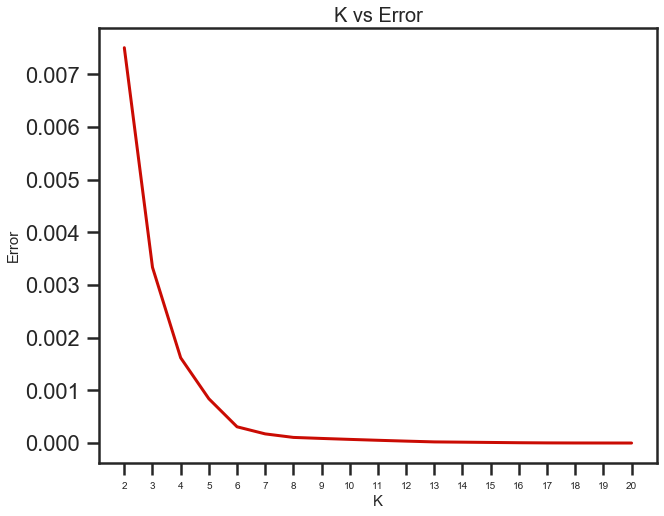

In [36]:

plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error", fontsize=20)
plt.xticks(range(2, 21),fontsize=10)
plt.xlabel("K",fontsize=15)
plt.ylabel("Error",fontsize=15)

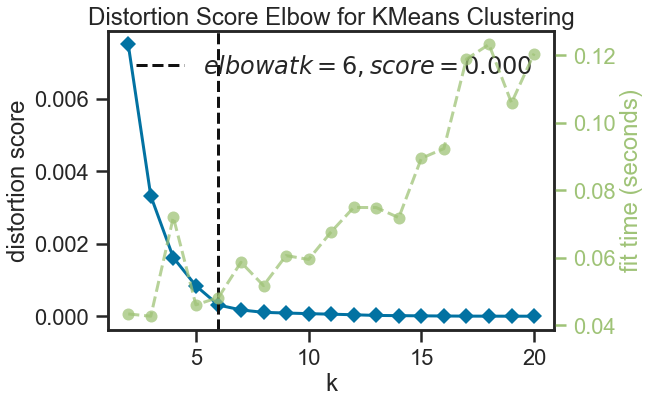

In [37]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

We see that the optimum K value is 6. So we will have a resulting of 6 clusters

In [38]:
kclusters = 6

riga_grouped_clustering = gym_fit.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(riga_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 5, 0, 0, 5, 0, 0, 4, 0], dtype=int32)

In [40]:
# create a new dataframe that includes the cluster .
riga_merged = gym_fit.copy()

# add clustering labels
riga_merged["Cluster Labels"] = kmeans.labels_
riga_merged.head()


Neighborhood  Gym / Fitness Center  Cluster Labels
0   Agenskalns              0.040000               1
1     Atgazene              0.045455               1
2        Avoti              0.030000               5
3    Beberbeki              0.000000               0
4        Bergi              0.000000               0

In [41]:
# merge riga_merged with riga_venues to add latitude/longitude for each neighborhood
riga_merged = riga_merged.join(riga_venues.set_index("Neighborhood"), on="Neighborhood")

print(riga_merged.shape)
riga_merged.head()

(3183, 10)


Neighborhood  Gym / Fitness Center  Cluster Labels  Neighborhood Latitude  \
0   Agenskalns                  0.04               1               56.93937   
0   Agenskalns                  0.04               1               56.93937   
0   Agenskalns                  0.04               1               56.93937   
0   Agenskalns                  0.04               1               56.93937   
0   Agenskalns                  0.04               1               56.93937   

   Neighborhood Longitude                     Venue                  Venue ID  \
0                24.06986  Kalnciema Ielas Tirdziņš  55696401498e5cfb90f1806c   
0                24.06986           Lokāls "Veldze"  587a0b4d6cea3f55dca98266   
0                24.06986              Grill Garden  4dc5716bc65b89d3ca6e2619   
0                24.06986                    Gandrs  4c518a213940be9aa3eb0409   
0                24.06986                Two Wheels  520a61a511d22636354e0bb9   

   Venue Latitude  Venue Longitude       Venue Category  
0       56.943122        24.066581               Market  
0       56.942170        24.064880                  Bar  
0       56.937511        24.071833            BBQ Joint  
0       56.944117        24.070368  Sporting Goods Shop  
0       56.945025        24.073640                Hotel

In [42]:
# sort the results by Cluster Labels
print(riga_merged.shape)
riga_merged.sort_values(["Cluster Labels"], inplace=True)
riga_merged.head()

(3183, 10)


Neighborhood  Gym / Fitness Center  Cluster Labels  Neighborhood Latitude  \
39        Salas                   0.0               0              56.871771   
7     Bolderaja                   0.0               0              57.031320   
7     Bolderaja                   0.0               0              57.031320   
7     Bolderaja                   0.0               0              57.031320   
7     Bolderaja                   0.0               0              57.031320   

    Neighborhood Longitude                        Venue  \
39               24.271986                      Visdari   
7                24.055710           Power Fitness Club   
7                24.055710            Buļļupes pludmale   
7                24.055710  Grilla Restorans Roza Perle   
7                24.055710                 Burgernīca🍔🍟   

                    Venue ID  Venue Latitude  Venue Longitude  \
39  525146d111d2cba31ac48842       56.870282        24.274182   
7   533ae975498ecd246ad5c8df       57.032397        24.050014   
7   4f8bed5ee4b0af04c2c3fa45       57.038284        24.032992   
7   4f27892ce4b08c160558bd18       57.034524        24.042381   
7   56642d1838fa50a7892db6c6       57.041885        24.031879   

          Venue Category  
39             BBQ Joint  
7                    Gym  
7                  Beach  
7             Steakhouse  
7   Fast Food Restaurant

In [43]:
riga_merged['Venue Category'].value_counts()['Gym / Fitness Center']

103

We see that there are a total of 103 locations with Gym / Fitness Center in Riga

We will create map using the Folium package in Python and each neighbourhood was coloured based on the cluster label and population age(15-49).

In [264]:
# Creating map of Riga with population 15-49
riga_map = folium.Map(location=[riga_latitude, riga_longitude], zoom_start=12,tiles='openstreetmap')
                   
riga_map.choropleth(
    geo_data='/Users/julija/IT/Coursera_Capstone/Apkaimes.json',
    data=riga_data,
    columns=['Neighborhood','Age 15-49'],
    key_on='feature.properties.apkaime',
    fill_color='OrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2, 
    legend_name = 'Population (age 15-49) by neighborhood'
)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]


# add markers to the map
markers_colors = ['red', 'purple','aquamarine', 'blue','green', 'darkorange']
for lat, lon, poi, cluster in zip(riga_merged['Neighborhood Latitude'], riga_merged['Neighborhood Longitude'], riga_merged['Neighborhood'], riga_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=markers_colors[cluster],
        fill_color=markers_colors[cluster],
        fill_opacity=0.8).add_to(riga_map)
riga_map

### 4. Analysis and Results

How many Neighborhoods per Cluster?

In [59]:
gym_fit["Cluster Labels"] = kmeans.labels_
gym_fit

Neighborhood  Gym / Fitness Center  Cluster Labels
0             Agenskalns              0.040000               1
1               Atgazene              0.045455               1
2                  Avoti              0.030000               5
3              Beberbeki              0.000000               0
4                  Bergi              0.000000               0
5                Bierini              0.030000               5
6              Bisumuiza              0.000000               0
7              Bolderaja              0.000000               0
8                  Brasa              0.060000               4
9                 Breksi              0.000000               0
10               Bukulti              0.000000               0
11                 Bulli              0.000000               0
12                Centrs              0.020000               3
13           Ciekurkalns              0.030000               5
14             Darzciems              0.080000               2
15               Darzini              0.000000               0
16           Daugavgriva              0.000000               0
17              Dreilini              0.000000               0
18             Dzirciems              0.050000               1
19           Grizinkalns              0.040000               1
20             Ilguciems              0.055556               4
21                Imanta              0.042857               1
22             Jaunciems              0.000000               0
23                 Jugla              0.015152               3
24            Katlakalns              0.017544               3
25             Kengarags              0.062500               4
26               Kipsala              0.020000               3
27               Kleisti              0.000000               0
28            Mangalsala              0.000000               0
29     Maskavas forstate              0.000000               0
30             Mezaparks              0.034483               5
31              Mezciems              0.000000               0
32             Milgravis              0.000000               0
33             Mukupurvs              0.044444               1
34  Petersala-Andrejsala              0.050000               1
35             Plavnieki              0.058824               4
36            Pleskodale              0.050000               1
37             Purvciems              0.060606               4
38               Rumbula              0.032258               5
39                 Salas              0.000000               0
40            Sampeteris              0.030000               5
41         Sarkandaugava              0.014286               3
42               Skanste              0.050000               1
43             Skirotava              0.085714               2
44                Spilve              0.000000               0
45                  Suzi              0.000000               0
46                 Teika              0.030000               5
47            Tornakalns              0.020000               3
48             Trisciems              0.000000               0
49                Vecaki              0.000000               0
50            Vecdaugava              0.000000               0
51          Vecmilgravis              0.000000               0
52            Vecpilseta              0.010000               3
53                Voleri              0.000000               0
54             Zasulauks              0.030000               5
55         Ziepniekkalns              0.031250               5
56              Zolitude              0.042254               1

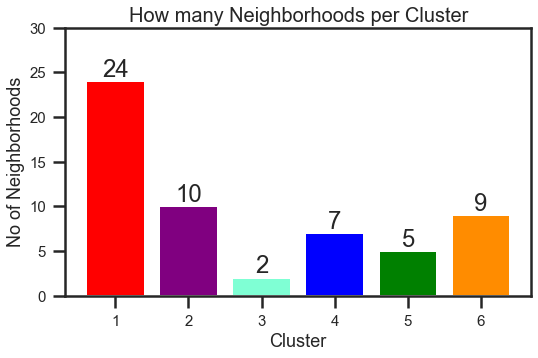

In [265]:
objects = (1,2,3,4,5,6)
y_pos = np.arange(len(objects))
performance = gym_fit['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()

opacity = 0.4
bar_width = 0.35
plt.ylabel('No of Neighborhoods', fontsize = 18)
plt.xlabel('Cluster', fontsize = 18)
plt.title('How many Neighborhoods per Cluster', fontsize = 20)
bar1= plt.bar(y_pos, perf, align='center', alpha=1, color=[ 'red', 'purple','aquamarine', 'blue','green', 'darkorange' ])

plt.xticks(y_pos, objects, fontsize = 15)
plt.yticks(range(0,35,5), fontsize = 15)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [139]:
# This will create a dataframe with  neighborhood which we will merge with each cluster dataframe
df_new = riga_data['Neighborhood']
df_new

0            Sarkandaugava
1            Ziepniekkalns
2             Vecmilgravis
3              Daugavgriva
4              Kundzinsala
5              Ciekurkalns
6                Bisumuiza
7               Tornakalns
8               Agenskalns
9                Dzirciems
10              Mangalsala
11              Vecpilseta
12                  Centrs
13              Pleskodale
14              Sampeteris
15               Mukupurvs
16               Beberbeki
17               Ilguciems
18               Bolderaja
19                   Bulli
20               Trisciems
21               Jaunciems
22               Mezaparks
23               Purvciems
24               Plavnieki
25               Darzciems
26               Kengarags
27               Skirotava
28                Mezciems
29                Dreilini
30       Maskavas forstate
31                Zolitude
32                 Kipsala
33                 Bukulti
34                 Rumbula
35                 Darzini
36                 Bierini
3

#### Cluster 1 - RED

In [267]:
cluster1 = riga_merged.loc[riga_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()


Neighborhood  Gym / Fitness Center  Cluster Labels  Neighborhood Latitude  \
0  Vecmilgravis                   0.0               0               57.03612   
1  Vecmilgravis                   0.0               0               57.03612   
2  Vecmilgravis                   0.0               0               57.03612   
3  Vecmilgravis                   0.0               0               57.03612   
4  Vecmilgravis                   0.0               0               57.03612   

   Neighborhood Longitude                                     Venue  \
0                 24.0967         Bérnu rotaļu laukums pie Daugavas   
1                 24.0967                                 Pica Lulū   
2                 24.0967                                  La Creme   
3                 24.0967  Olympic Casino & OlyBet Sports Bar 00-24   
4                 24.0967                                      Nika   

                   Venue ID  Venue Latitude  Venue Longitude Venue Category  
0  51811e38498e034fb2fa5b2e       57.028287        24.101397     Playground  
1  5ad612abad910e2579e4ce10       57.033510        24.105140    Pizza Place  
2  4d7fbab2ebc154819f57f9a6       57.035354        24.098442         Bakery  
3  531c7ff611d28bf9ecbf53f7       57.031664        24.109788         Casino  
4  4d512bf29ffc236a841320a7       57.035519        24.118455            Bar

In [134]:
df_cluster1.sort_values(["Gym / Fitness Center"], ascending=False)

Neighborhood  Gym / Fitness Center  Cluster Labels  \
0    Vecmilgravis                   0.0               0   
351        Spilve                   0.0               0   
365        Voleri                   0.0               0   
364        Voleri                   0.0               0   
363        Voleri                   0.0               0   
..            ...                   ...             ...   
172     Trisciems                   0.0               0   
171         Bulli                   0.0               0   
170         Bulli                   0.0               0   
169         Bulli                   0.0               0   
532         Salas                   0.0               0   

     Neighborhood Latitude  Neighborhood Longitude  \
0                57.036120               24.096700   
351              56.999170               24.072390   
365              57.013320               24.073020   
364              57.013320               24.073020   
363              57.013320               24.073020   
..                     ...                     ...   
172              57.052490               24.130150   
171              57.000000               23.983330   
170              57.000000               23.983330   
169              57.000000               23.983330   
532              56.871771               24.271986   

                                 Venue                  Venue ID  \
0    Bérnu rotaļu laukums pie Daugavas  51811e38498e034fb2fa5b2e   
351                        Voleru Mols  51f4ebb4498ee36a4104be19   
365          Rīgas jūras osta “Voleri”  4dd7a5a0c65bee535ab69f3f   
364                    Piestatne KS-34  512b0794e4b0c87c9379983c   
363                bolderajas Pludmale  51ab55bf498ed3e626d54135   
..                                 ...                       ...   
172          Vecdaugavas dabas liegums  4da98741f7b145b36ff8c08e   
171                   Buļļupes ainavas  53526d96498e9ecbd66ef978   
170               IDE Hotel www.ide.lv  4d962c48a2c654814375b953   
169          Mežāres, Viesu Nams "IDE"  5436c180498ed30e8d7ff63e   
532                         Dūmu Krogs  5006bb0de4b09db42e258e6d   

     Venue Latitude  Venue Longitude   Venue Category  
0         57.028287        24.101397       Playground  
351       56.992860        24.086753  Harbor / Marina  
365       57.004158        24.088037  Harbor / Marina  
364       57.008138        24.096289             Pier  
363       56.996639        24.071694            Beach  
..              ...              ...              ...  
172       57.056395        24.103839             Park  
171       57.011793        23.977335       Campground  
170       56.986734        23.996626            Hotel  
169       56.987055        23.994043   Boarding House  
532       56.870785        24.271578        Gastropub  

[533 rows x 10 columns]

In [245]:
print('There are {} uniques venues.'.format(len(df_cluster1['Venue'].unique())))
"Gym / Fitness Center" in df_cluster1['Venue Category'].unique()

There are 362 uniques venues.


False

#### Cluster 2 - PURPLE

In [137]:
cluster2=riga_merged.loc[riga_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()

Neighborhood  Gym / Fitness Center  Cluster Labels  Neighborhood Latitude  \
0   Agenskalns                  0.04               1               56.93937   
1   Agenskalns                  0.04               1               56.93937   
2   Agenskalns                  0.04               1               56.93937   
3   Agenskalns                  0.04               1               56.93937   
4   Agenskalns                  0.04               1               56.93937   

   Neighborhood Longitude                     Venue                  Venue ID  \
0                24.06986  Kalnciema Ielas Tirdziņš  55696401498e5cfb90f1806c   
1                24.06986                  Float.lv  51026029e4b02714c3a7ea7a   
2                24.06986      My Fitness | Olimpia  4be667a65254d13ae99f60e1   
3                24.06986                 Vinilbārs  52dfa39111d2d422e8e047c6   
4                24.06986                   Bonitta  4db678e16a23c31a033f6f84   

   Venue Latitude  Venue Longitude        Venue Category  
0       56.943122        24.066581                Market  
1       56.943357        24.095249                   Spa  
2       56.949608        24.083514  Gym / Fitness Center  
3       56.942726        24.065883                   Bar  
4       56.952365        24.084182        Massage Studio

In [112]:
df_cluster2.sort_values(["Gym / Fitness Center"], ascending=False).head()


Neighborhood  Gym / Fitness Center  Cluster Labels  \
245            Pleskodale                  0.05               1   
619  Petersala-Andrejsala                  0.05               1   
608  Petersala-Andrejsala                  0.05               1   
609  Petersala-Andrejsala                  0.05               1   
610  Petersala-Andrejsala                  0.05               1   

     Neighborhood Latitude  Neighborhood Longitude             Venue  \
245               56.93146                24.03649           Route88   
619               56.96556                24.09472         Esplanāde   
608               56.96556                24.09472  CrossFit Rīdzene   
609               56.96556                24.09472     Klubs "Nauda"   
610               56.96556                24.09472           Pagalms   

                     Venue ID  Venue Latitude  Venue Longitude  \
245  548b3608498e2d4a132f509a       56.926791        24.040669   
619  4bbf8cff4cdfc9b608759121       56.954746        24.114754   
608  52ee91e1498eb46f763dcc78       56.974720        24.104693   
609  4fb81f58e4b0f914e0bc22f5       56.964770        24.078040   
610  559418f4498ebeb409dde02c       56.954616        24.104573   

           Venue Category  
245             BBQ Joint  
619                  Park  
608  Gym / Fitness Center  
609             Nightclub  
610                Lounge

In [244]:
print('There are {} uniques venues.'.format(len(df_cluster2['Venue'].unique())))
print("Gym / Fitness Center" in df_cluster2['Venue Category'].unique())
print('There are {} Gym/Fitness Center.'.format(df_cluster2['Venue Category'].value_counts(ascending=False)['Gym / Fitness Center']))

There are 543 uniques venues.
True
There are 38 Gym/Fitness Center.


#### Cluster 3 - TURQUOISE/ aquamarine

In [114]:

cluster3 = riga_merged.loc[riga_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()

Neighborhood  Gym / Fitness Center  Cluster Labels  Neighborhood Latitude  \
0    Darzciems                  0.08               2               56.94213   
1    Darzciems                  0.08               2               56.94213   
2    Darzciems                  0.08               2               56.94213   
3    Darzciems                  0.08               2               56.94213   
4    Darzciems                  0.08               2               56.94213   

   Neighborhood Longitude                       Venue  \
0                24.18494                       Titan   
1                24.18494    AURA | Salons, frizētava   
2                24.18494  Rimi Hipermārkets [Stirnu]   
3                24.18494                   T/C Green   
4                24.18494                  Sushi Shop   

                   Venue ID  Venue Latitude  Venue Longitude  \
0  4d00fedf4f56b60c67dea437       56.932124        24.207546   
1  50afa79ce4b00d9395e9dd98       56.944470        24.170429   
2  4c546eb96a4bb71326f43227       56.958416        24.185908   
3  5752b619498e75528b0da79f       56.944964        24.173156   
4  50d9c270e4b05cc5ef0bd9b8       56.945617        24.208752   

         Venue Category  
0  Gym / Fitness Center  
1    Salon / Barbershop  
2         Big Box Store  
3                Market  
4      Sushi Restaurant

In [247]:
print('There are {} uniques venues.'.format(len(df_cluster3['Venue'].unique())))
print("Gym / Fitness Center" in df_cluster3['Venue Category'].unique())
print('There are {} Gym/Fitness Center.'.format(df_cluster3['Venue Category'].value_counts(ascending=False)['Gym / Fitness Center']))

There are 103 uniques venues.
True
There are 11 Gym/Fitness Center.


#### Cluster 4 - BLUE

In [116]:
cluster4 = riga_merged.loc[riga_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()

Neighborhood  Gym / Fitness Center  Cluster Labels  Neighborhood Latitude  \
0  Sarkandaugava              0.014286               3               56.98857   
1  Sarkandaugava              0.014286               3               56.98857   
2  Sarkandaugava              0.014286               3               56.98857   
3  Sarkandaugava              0.014286               3               56.98857   
4  Sarkandaugava              0.014286               3               56.98857   

   Neighborhood Longitude                                              Venue  \
0                24.12164                       Latvijas Finieris atgriezumi   
1                24.12164                                            Tik Tak   
2                24.12164  LDz | Dzelzceļa stacija “Sarkandaugava” (SARKA...   
3                24.12164                                  Čarlstons Express   
4                24.12164                                Jūrnieks Hotel Riga   

                   Venue ID  Venue Latitude  Venue Longitude Venue Category  
0  4f7558bae4b06c81e0a07d65       56.981858        24.117170     Hobby Shop  
1  504902a8e4b06b90916c37c3       56.976028        24.135973          Diner  
2  502006bee4b09c1a7062b1c9       56.993061        24.133714  Train Station  
3  508906c3e4b0db195ec061a3       56.977782        24.136235           Café  
4  4bc87c77dc55eee1917ee8ac       56.999351        24.119901          Hotel

In [249]:
print('There are {} uniques venues.'.format(len(df_cluster4['Venue'].unique())))
print("Gym / Fitness Center" in df_cluster4['Venue Category'].unique())
print('There are {} Gym/Fitness Center.'.format(df_cluster4['Venue Category'].value_counts(ascending=False)['Gym / Fitness Center']))

There are 477 uniques venues.
True
There are 10 Gym/Fitness Center.


#### Cluster 5 - GREEN

In [118]:
cluster5 = riga_merged.loc[riga_merged['Cluster Labels'] == 4]
df_cluster5 = pd.merge(df_new, cluster5, on='Neighborhood')
df_cluster5.head()

Neighborhood  Gym / Fitness Center  Cluster Labels  Neighborhood Latitude  \
0    Ilguciems              0.055556               4               56.97035   
1    Ilguciems              0.055556               4               56.97035   
2    Ilguciems              0.055556               4               56.97035   
3    Ilguciems              0.055556               4               56.97035   
4    Ilguciems              0.055556               4               56.97035   

   Neighborhood Longitude               Venue                  Venue ID  \
0                24.05994     Ziedu Ekspresis  4d849c2b61676dcbe5a275e4   
1                24.05994  Andrejsala / Siena  518130e8498e79c2cb6c9b8e   
2                24.05994      Balasta Dambis  4d7273ced976236a1b9a0679   
3                24.05994      Nellijas pirts  5051b59ae4b06a9490cd4036   
4                24.05994    Aviācijas Muzejs  4ff2fd48e4b00cc51ba841b6   

   Venue Latitude  Venue Longitude  Venue Category  
0       56.974705        24.040855     Flower Shop  
1       56.970926        24.092477          Lounge  
2       56.958509        24.084736  Scenic Lookout  
3       56.963427        24.061836             Spa  
4       56.976149        24.072461   Historic Site

In [250]:
print('There are {} uniques venues.'.format(len(df_cluster5['Venue'].unique())))
print("Gym / Fitness Center" in df_cluster5['Venue Category'].unique())
print('There are {} Gym/Fitness Center.'.format(df_cluster5['Venue Category'].value_counts(ascending=False)['Gym / Fitness Center']))

There are 316 uniques venues.
True
There are 22 Gym/Fitness Center.


#### Cluster 6 - ORANGE

In [140]:

cluster6 = riga_merged.loc[riga_merged['Cluster Labels'] == 5]
df_cluster6 = pd.merge(df_new, cluster6, on='Neighborhood')
df_cluster6.head()

Neighborhood  Gym / Fitness Center  Cluster Labels  Neighborhood Latitude  \
0  Ziepniekkalns               0.03125               5               56.89951   
1  Ziepniekkalns               0.03125               5               56.89951   
2  Ziepniekkalns               0.03125               5               56.89951   
3  Ziepniekkalns               0.03125               5               56.89951   
4  Ziepniekkalns               0.03125               5               56.89951   

   Neighborhood Longitude                          Venue  \
0                24.09832                 VANS kafejnica   
1                24.09832  BK Kolibri/47.vsk Sporta Zāle   
2                24.09832             Pica Lulū picērija   
3                24.09832                     McDonald's   
4                24.09832         Turība | Café "Turība"   

                   Venue ID  Venue Latitude  Venue Longitude  \
0  4e34438db0fb59390e91dfe4       56.899562        24.084457   
1  528aeb0e11d2ed2fd8ae1379       56.915933        24.103235   
2  4cdb1669c409b60c18a8d21a       56.907834        24.082500   
3  4f678d4e7b0cfc7ca4ba1059       56.907041        24.082914   
4  50446f06e4b072dc97417d9c       56.910085        24.081150   

              Venue Category  
0  Middle Eastern Restaurant  
1           Basketball Court  
2                Pizza Place  
3       Fast Food Restaurant  
4                       Café

In [251]:
print('There are {} uniques venues.'.format(len(df_cluster6['Venue'].unique())))
print("Gym / Fitness Center" in df_cluster6['Venue Category'].unique())
print('There are {} Gym/Fitness Center.'.format(df_cluster6['Venue Category'].value_counts(ascending=False)['Gym / Fitness Center']))

There are 503 uniques venues.
True
There are 22 Gym/Fitness Center.


#### Average number of Gym/Fitness Center per Cluster

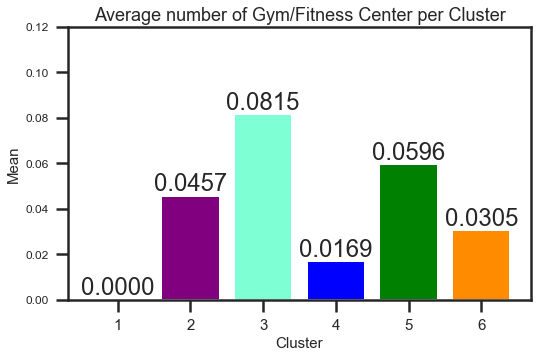

In [270]:
clusters_mean = [df_cluster1['Gym / Fitness Center'].mean(),df_cluster2['Gym / Fitness Center'].mean(),df_cluster3['Gym / Fitness Center'].mean(),
                 df_cluster4['Gym / Fitness Center'].mean(),df_cluster5['Gym / Fitness Center'].mean(),df_cluster6['Gym / Fitness Center'].mean()]
objects = (1,2,3,4,5,6)
y_pos = np.arange(len(objects))
perf = clusters_mean 
opacity = 0.3
bar_width = 1
plt.ylabel('Mean', fontsize = 15)
plt.xlabel('Cluster', fontsize = 15)
plt.title('Average number of Gym/Fitness Center per Cluster', fontsize = 18)
bar1= plt.bar(y_pos, perf, align='center', alpha=1, color=['red', 'purple','aquamarine', 'blue','green', 'darkorange'])
plt.xticks(y_pos, objects, fontsize = 15)
plt.yticks([0, 0.02, 0.04, 0.06,0.08,0.1, 0.12], fontsize = 12)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f' % height, ha='center', va='bottom')

plt.tight_layout()
plt.show()
